<a href="https://colab.research.google.com/github/ManjunathD620/Conditional_GAN/blob/main/Fashion_cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [ ]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):

	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)

	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	in_image = Input(shape=in_shape)
	merge = Concatenate()([in_image, li])
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)
	out_layer = Dense(1, activation='sigmoid')(fe)

	model = Model([in_image, in_label], out_layer)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


In [ ]:
def define_generator(latent_dim, n_classes=10):

	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
 
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	li = Reshape((7, 7, 1))(li)
	in_lat = Input(shape=(latent_dim,))
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	merge = Concatenate()([gen, li])
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
 
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	model = Model([in_lat, in_label], out_layer)
	return model

In [ ]:
def define_gan(g_model, d_model):

	d_model.trainable = False
	gen_noise, gen_label = g_model.input
	gen_output = g_model.output
	
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [ ]:
def load_real_samples():
	(trainX, trainy), (_, _) = load_data()
	X = expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = X/255.0
	return [X, trainy]

In [ ]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y

In [ ]:
import matplotlib.pyplot as plt

def generate_latent_points(latent_dim, n_samples, n_classes=10):

	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]


def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y


def test(dataset):
  [X_fake,label], y_fake = generate_fake_samples(g_model, 100, 20)
  _,acc = d_model.evaluate([X_fake, label], y_fake,verbose=1)
  print(f"Accuracy = {acc}")
  for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_fake[i].reshape(28,28))
  plt.show()


In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
	bat_per_epo = dataset[0].shape[0] // n_batch
	half_batch = n_batch // 2

	for i in range(n_epochs):
		for j in range(bat_per_epo):
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
		
		if(i%2 == 0) :
			test(dataset)

	g_model.save('/content/drive/MyDrive/Major Project/fashion_cgan.h5')

In [ ]:
d_model = define_discriminator()
g_model = define_generator(100)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()

1/1 [==============================] - 0s 20ms/step - loss: 0.5838 - accuracy: 0.9500
Accuracy = 0.949999988079071


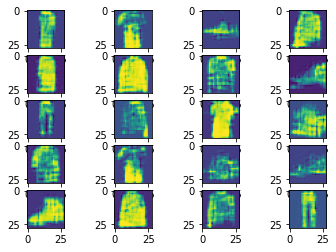

1/1 [==============================] - 0s 23ms/step - loss: 0.4867 - accuracy: 1.0000
Accuracy = 1.0


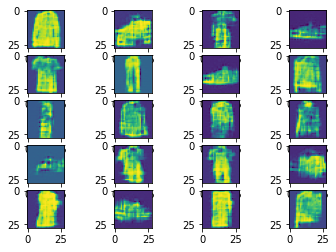

1/1 [==============================] - 0s 19ms/step - loss: 0.5162 - accuracy: 0.9500
Accuracy = 0.949999988079071


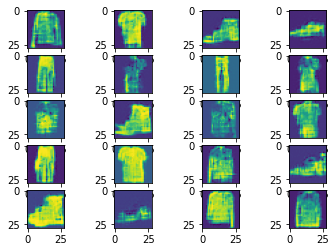

1/1 [==============================] - 0s 25ms/step - loss: 0.3640 - accuracy: 0.9500
Accuracy = 0.949999988079071


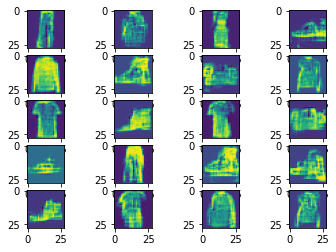

1/1 [==============================] - 0s 20ms/step - loss: 0.4398 - accuracy: 1.0000
Accuracy = 1.0


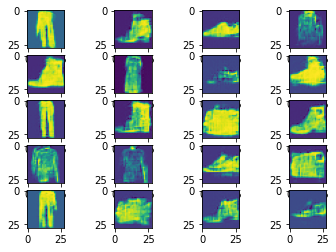

1/1 [==============================] - 0s 20ms/step - loss: 0.4878 - accuracy: 0.8500
Accuracy = 0.8500000238418579


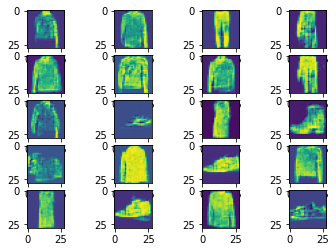

1/1 [==============================] - 0s 21ms/step - loss: 0.3892 - accuracy: 0.9500
Accuracy = 0.949999988079071


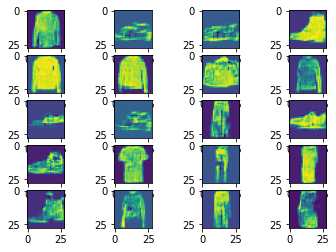

1/1 [==============================] - 0s 25ms/step - loss: 0.4212 - accuracy: 1.0000
Accuracy = 1.0


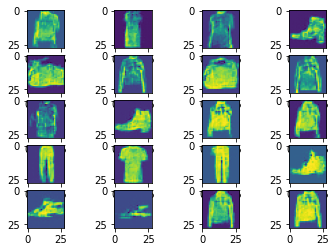

1/1 [==============================] - 0s 22ms/step - loss: 0.4017 - accuracy: 1.0000
Accuracy = 1.0


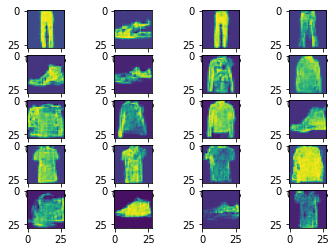

1/1 [==============================] - 0s 21ms/step - loss: 0.4274 - accuracy: 0.9000
Accuracy = 0.8999999761581421


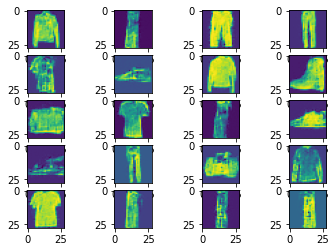

In [ ]:
train(g_model, d_model, gan_model, dataset,100)